In [5]:
import pandas as pd
import numpy as np
import pysindy as ps
import math
from numpy import diff

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso

In [8]:
# t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-t.csv')
# x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-x.csv')
# xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-62-x.csv')
# t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-t.csv')
# x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-x.csv')
# xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-63-x.csv')

t = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-12-t.csv')
x = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-12-x.csv')
xdot = pd.read_csv (r'C:\Users\l2016\GitHub\nonlinear-brain-mass-model\data-fit\data-12-x.csv')

t = t.to_numpy() #0 to 1000
x = x.to_numpy() #1039 by 16
xdot = xdot.to_numpy()
print(x.shape[0])
# print(type(x))
#print(x[:,2])

10421


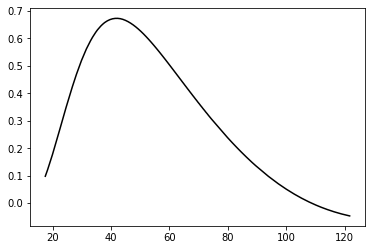

In [9]:
cl1 = x[:,1] - x[:,2]
plt.plot(t, cl1,'k')

In [12]:
#the case 1 with one column 
#
#create the training data
#index = math.floor(len(t)/2)#519
index = x.shape[0]
#test 1 use u as a input
im = 0
t_train = t[im: index].flatten()

print(t_train.shape)
#training data
x_train = x [im:index]
x_dot_train = xdot [im:index]
#rint(x_train)
#it also need to y term which is x 2nd column - 3rd column
y = np.array([x[im:index,1] - x[im:index,2]])
#print(y.shape)
#concatenate the y to x_train 
x_train = np.concatenate((x_train, y.T), axis=1)
print(x_train.shape)

#compute the y_dot 
dydt =np.array([xdot[im:index,1] - xdot[im:index,2]])

#concatenate to x_dot_train
x_dot_train = np.concatenate((x_dot_train, dydt.T), axis=1)
print(x_dot_train.shape)

# test 2
#I will try to include u as one of the training input as well
#can I fit u to a single hill wave function with reasonable width
#and then pass it to the model as a input

(10421,)
(10421, 9)
(10421, 9)


In [13]:
#I will initial with only 2 functions: one is x 
# the other is the sigmoid-liked function
library_functions = [
    lambda x : x,
    lambda x : -2.5+5/(1+np.exp(-0.56*x)) #-e0+2*e0/(1+exp(-r*x))
]
library_function_names = [
    lambda x : x,
    lambda x : 'S(' + x + ')'
]

custom_library = ps.CustomLibrary(
    library_functions=library_functions, function_names=library_function_names
)

In [15]:
#pass the x and its derivative
#updated the threshold:
#minimum coefficient 0.0026 hi*gamma4/ti
optimizer = ps.STLSQ(threshold=0.001)
feature_library=custom_library
dt = 0.01
model = ps.SINDy(
    feature_library=feature_library,
    optimizer = optimizer
)
model.fit(x_train, t=dt, x_dot=x_dot_train)
model.print()

(x0)' = 1.000 x0
(x1)' = 0.667 x1 + 0.333 x2 + 0.333 x8
(x2)' = 0.333 x1 + 0.667 x2 + -0.333 x8
(x3)' = 1.000 x3
(x4)' = 1.000 x4
(x5)' = 1.000 x5
(x6)' = 1.000 x6
(x7)' = 1.000 x7
(x8)' = 0.333 x1 + -0.333 x2 + 0.667 x8


In [21]:
print('Model score: %f' % model.score(x_train))

Model score: -15629721.445769


[1.15290132e+00 9.76751684e-02 1.85770991e-05 3.98969240e-02
 2.87658596e-02 1.54528631e-05 7.73170569e-04 4.30119751e-04
 9.76565913e-02]


C:\Users\l2016\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


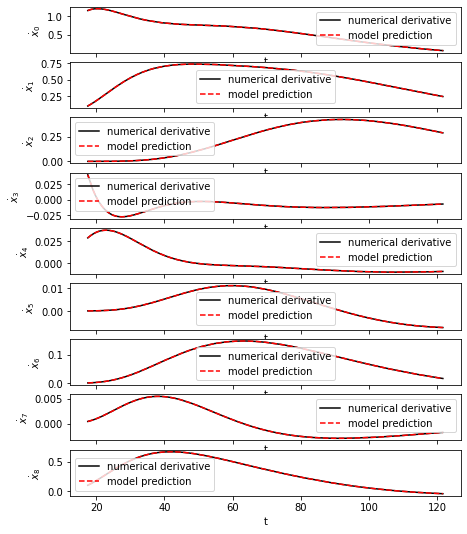

In [32]:
print(x_train[0,:])
#x test doing split
x_dot_test_predicted = model.predict(x_train)

fig, axs = plt.subplots(x_train.shape[1], 1, sharex=True, figsize=(7, 9))
for i in range(x_train.shape[1]):
    axs[i].plot(t_train, x_dot_train[:, i],
                'k', label='numerical derivative')
    axs[i].plot(t_train, x_dot_test_predicted[:, i],
                'r--', label='model prediction')
    axs[i].legend()
    axs[i].set(xlabel='t', ylabel='$\dot x_{}$'.format(i))
fig.show()

In [28]:
#simulate the result
dt = 0.1
t_test = np.arange(0, 200, dt)
#use the x_train at 10 ms value as x0_test
x0_test = x_train[0,:]
x_test_sim = model.simulate(x0_test, t_test)
print(x_test_sim.shape[0])

cl1_sim = x_test_sim[:,1] - x_test_sim[:,2]
#cl2_sim = x_test_sim[:,9] - x_test_sim[:,10]
print(cl1_sim.shape)
#print(cl2_sim.shape)

cl1 = x[:,1] - x[:,2]
#cl2 = x[:,9] - x[:,10]

#print(cl1)
#print(cl2.shape)

2000
(2000,)


(0, 1)

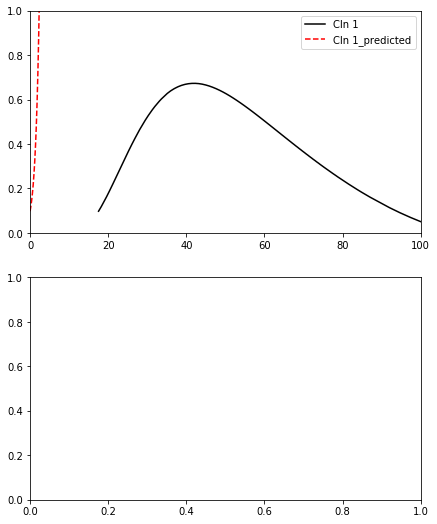

In [30]:
fig, ax = plt.subplots(2, 1, figsize=(7, 9))
ax[0].plot(t, cl1,'k')
ax[0].plot( t_test, cl1_sim, 'r--')
ax[0].legend(['Cln 1','Cln 1_predicted'])
ax[0].set_xlim([0, 100])
ax[0].set_ylim([0, 1])
# ax[1].plot(t, cl2,'k', t_test, cl2_sim, 'r--')
# ax[1].legend(['Cln 2','Cln 2_predicted'])